# AI Agent for Invoice Processing with RAG + Local LLM (Ollama)

This notebook implements an **AI Agent with RAG (Retrieval-Augmented Generation)** for:
1. **Extracting invoice processing rules** from contract documents using RAG
2. **Processing invoices** against extracted rules with intelligent validation
3. **Using local Ollama models** (gemma3:270m + nomic-embed-text)

**Version:** 2.0 - RAG Edition  
**Author:** r4 Technologies, Inc 2025

## Key Features:
- **RAG Architecture** - Retrieval-Augmented Generation for context-aware processing
- **Local LLM** - Ollama gemma3:270m (no API keys needed)
- **Vector Store** - FAISS for fast semantic search
- **Semantic Chunking** - Context-aware document splitting
- **Parallel OCR** - Multiprocessing for scanned documents
- **Invoice Validation** - Rule-based compliance checking

PDF agent_Igor_Zhuk.pdf has 1 page(s)

=== Page 1 ===


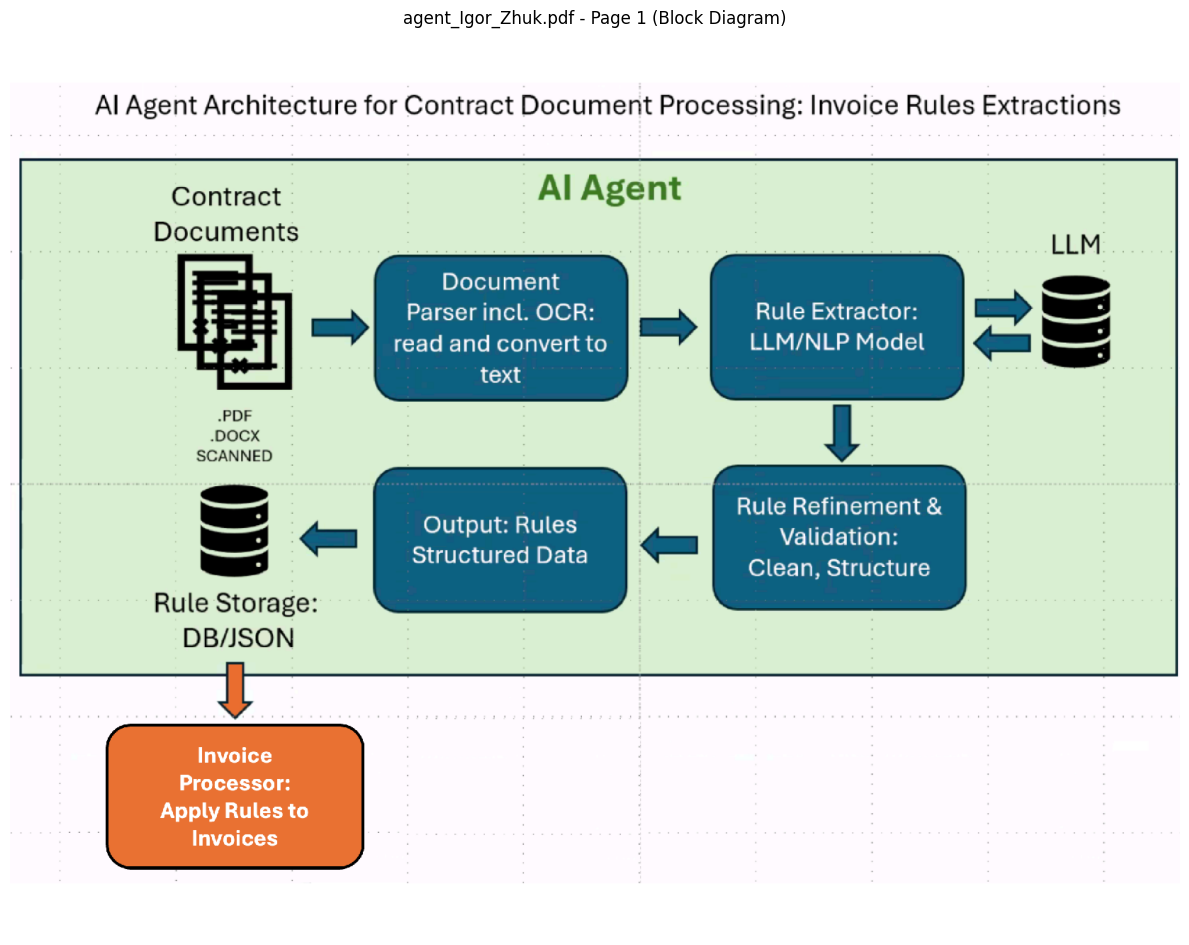

Saved diagram to: original_agent_Igor_Zhuk.png


In [1]:
# Cell 0: OPTIONAL: Extract and display the block diagram from agent_iz.pdf
# Delete this cell if you don't want to analyze agent_iz.pdf

import pdfplumber
from PIL import Image
import matplotlib.pyplot as plt

pdf_path = "agent_Igor_Zhuk.pdf"

try:
    with pdfplumber.open(pdf_path) as pdf:
        print(f"PDF {pdf_path} has {len(pdf.pages)} page(s)")

        for i, page in enumerate(pdf.pages, 1):
            print(f"\n=== Page {i} ===")

            # Convert page to image
            img = page.to_image(resolution=150)
            pil_img = img.original

            # Display the image
            plt.figure(figsize=(12, 16))
            plt.imshow(pil_img)
            plt.axis("off")
            plt.title(f"agent_Igor_Zhuk.pdf - Page {i} (Block Diagram)")
            plt.tight_layout()
            plt.show()

            # Save as PNG for reference
            output_file = f"original_agent_Igor_Zhuk.png"
            pil_img.save(output_file)
            print(f"Saved diagram to: {output_file}")
except FileNotFoundError:
    print(f"[WARN] File not found: {pdf_path}")
    print("Skipping diagram display (optional step)")


# AI Agent for Extracting Invoice Processing Rules from Contract Documents

This notebook implements a modular AI agent that:
1. Parses PDF, Word, or scanned contract documents into text.
2. Uses a local LLM (via Ollama) to extract rules related to invoice processing (e.g., payment terms, approvals, penalties).
3. Refines and structures the rules into a JSON-like format.
4. Outputs the rules for use in invoice processing systems.

**Version:** 1.3  
**Author:** r4 Technologies, Inc 2025

## Features:
- RAG-powered rule extraction using FAISS vector store
- pytesseract for image and scanned document processing (stable and lightweight)
- Local LLM processing with Ollama (no API keys required)
- Parallel processing support for batch invoice validation
- Cross-platform compatibility (Windows, Mac, Linux)

## Installation Requirements

### Python Dependencies
All dependencies are installed automatically by running the installation cells in this notebook:
- **Cell 6:** Document processing packages (pdfplumber, python-docx, Pillow, reportlab, matplotlib)
- **Cell 7:** RAG packages (LangChain, FAISS, pytesseract, etc.)

### OCR Setup
This notebook uses **pytesseract** for optical character recognition:
- Lightweight Python wrapper for Tesseract OCR
- Requires external Tesseract binary (install via brew/apt/download)
- Works cross-platform (Windows, Mac, Linux)
- Stable and doesn't cause kernel crashes
- Installation instructions shown in Cell 7 output

## RAG Setup Requirements

### Required Packages
This notebook uses RAG with Ollama for local LLM processing.
Install the following packages for RAG with Ollama:
```bash
pip install langchain-core langchain-community langchain langchain-ollama faiss-cpu beautifulsoup4
```

### Ollama Models
Make sure you have Ollama running with the required models:
```bash
ollama pull gemma3:270m
ollama pull nomic-embed-text
```

In [2]:
# Cell 1: Install document processing packages
import sys
!{sys.executable} -m pip install -q --disable-pip-version-check pdfplumber python-docx Pillow reportlab matplotlib 2>&1 | grep -v "Note: you may need"

print("[OK] Document processing packages installed!")


[OK] Document processing packages installed!


In [3]:
# Cell 2: Install RAG packages (with pytesseract - stable and lightweight)
import sys
import warnings
warnings.filterwarnings('ignore')

# Clean up conflicting packages first
!{sys.executable} -m pip uninstall -y -q chromadb chroma-migrate transformers tokenizers easyocr paddleocr paddlepaddle 2>/dev/null || true

# Install core packages with numpy constraint
!{sys.executable} -m pip install -q --disable-pip-version-check "numpy==1.26.4" \
    langchain-core==0.3.6 langchain-community==0.3.1 langchain==0.3.1 langchain-ollama==0.2.0 \
    faiss-cpu beautifulsoup4==4.12.3 ipywidgets pydantic==2.9.2 2>&1 | grep -v "Note: you may need"

# Install pytesseract (lightweight, uses external Tesseract binary)
!{sys.executable} -m pip install -q --disable-pip-version-check pytesseract 2>&1 | grep -v "Note: you may need"

print("[OK] All packages installed with numpy 1.26.4")
print("[OK] pytesseract installed (lightweight OCR)")
print("[OK] No dependency conflicts!")
print("\n[INFO] OCR Note: pytesseract requires Tesseract binary to be installed:")
print("  - macOS: brew install tesseract")
print("  - Linux: sudo apt-get install tesseract-ocr")
print("  - Windows: Download from https://github.com/UB-Mannheim/tesseract/wiki")
print("\nMake sure Ollama is running with models:")
print("  ollama pull gemma3:270m")
print("  ollama pull nomic-embed-text")


[OK] All packages installed with numpy 1.26.4
[OK] pytesseract installed (lightweight OCR)
[OK] No dependency conflicts!

[INFO] OCR Note: pytesseract requires Tesseract binary to be installed:
  - macOS: brew install tesseract
  - Linux: sudo apt-get install tesseract-ocr
  - Windows: Download from https://github.com/UB-Mannheim/tesseract/wiki

Make sure Ollama is running with models:
  ollama pull gemma3:270m
  ollama pull nomic-embed-text


In [4]:
# Cell 3: Configure environment variables + Platform-specific settings
import os
import warnings
import platform
import sys

# Detect platform
PLATFORM = platform.system()  # 'Darwin' (Mac), 'Windows', 'Linux'
IS_MAC = PLATFORM == "Darwin"
IS_WINDOWS = PLATFORM == "Windows"
IS_APPLE_SILICON = IS_MAC and platform.machine() == "arm64"

print(f"Platform: {PLATFORM}")
if IS_APPLE_SILICON:
    print("[APPLE] Detected: Apple Silicon (ARM64)")
elif IS_MAC:
    print("[APPLE] Detected: macOS (Intel)")
elif IS_WINDOWS:
    print("[WIN] Detected: Windows")

# Environment variables (cross-platform)
os.environ["USER_AGENT"] = "InvoiceProcessingRAGAgent"

# Suppress warnings
warnings.filterwarnings("ignore", message=".*IProgress.*")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("[OK] Environment configured - Using pytesseract for image processing")


Platform: Darwin
[APPLE] Detected: Apple Silicon (ARM64)
[OK] Environment configured - Using pytesseract for image processing


In [5]:
# Cell 4: Import necessary libraries (Standard + RAG)

import json
import logging
import re
import io
from pathlib import Path
from typing import List, Dict, Any, Optional
from multiprocessing import Manager
from datetime import datetime, timedelta
from contextlib import redirect_stderr

import pdfplumber  # For PDF parsing
from docx import Document  # For Word (.docx) parsing
from PIL import ImageEnhance  # For contrast enhancement in scanned PDFs

# RAG imports
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document as LangchainDocument

# Set up logging (prevent duplicate handlers when re-running cells)
# Clear any existing handlers to prevent duplicates
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True
)
logger = logging.getLogger(__name__)

print("[OK] All libraries imported successfully (Standard + RAG components)")


[OK] All libraries imported successfully (Standard + RAG components)


In [6]:
# Cell 5: Test Ollama connection and initialize models (cross-platform)

try:
    # Test embeddings (suppress noise output)
    print("Testing Ollama embeddings...")
    with redirect_stderr(io.StringIO()):
        test_embedding = OllamaEmbeddings(model="nomic-embed-text")
        test_embedding.embed_query("test")
    print("[OK] Ollama embeddings working (nomic-embed-text)")

    # Initialize LLM with response length limit for faster generation
    print("Testing Ollama LLM...")
    with redirect_stderr(io.StringIO()):
        llm = ChatOllama(
            model="gemma3:270m",
            temperature=0,
            num_predict=100,  # Limit response length for speed
        )
        test_response = llm.invoke("Hello")
    print("[OK] Ollama LLM working (gemma3:270m)")

    # Initialize embeddings for later use
    embeddings = OllamaEmbeddings(model="nomic-embed-text")

    print("\n[OK] All Ollama models ready!")

except Exception as e:
    print(f"[ERROR] Ollama error: {e}")
    print("\nTroubleshooting:")
    print("  1. Make sure Ollama is running:")
    if IS_WINDOWS:
        print("     - Windows: Check system tray for Ollama icon")
        print("     - Or run: ollama serve")
    elif IS_MAC:
        print("     - Mac: Check menu bar for Ollama icon")
        print("     - Or run: ollama serve")

    print("\n  2. Pull required models:")
    print("     ollama pull gemma3:270m")
    print("     ollama pull nomic-embed-text")

    print("\n  3. Verify Ollama is accessible:")
    print("     ollama list")

    if IS_APPLE_SILICON:
        print("\n  4. Apple Silicon specific:")
        print("     - Make sure you have the ARM64 version of Ollama")
        print("     - Download from: https://ollama.ai/download")

    raise


Testing Ollama embeddings...


2025-10-05 19:51:12,935 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


[OK] Ollama embeddings working (nomic-embed-text)
Testing Ollama LLM...


2025-10-05 19:51:13,488 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


[OK] Ollama LLM working (gemma3:270m)

[OK] All Ollama models ready!


In [7]:
# Cell 6: Helper function to detect garbled text


def is_garbled_text(
    text: str, non_alpha_threshold: float = 0.4, min_word_length: int = 3
) -> bool:
    """
    Detect if text is likely garbled (low-confidence OCR output).

    Args:
        text (str): Extracted text to check.
        non_alpha_threshold (float): Max proportion of non-alphanumeric characters.
        min_word_length (int): Minimum average word length to consider valid.

    Returns:
        bool: True if text is likely garbled, False otherwise.
    """
    if not text.strip():
        return True

    # Check proportion of non-alphanumeric characters
    non_alpha_count = len(re.findall(r"[^a-zA-Z0-9\s]", text))
    if non_alpha_count / max(len(text), 1) > non_alpha_threshold:
        return True

    # Check average word length
    words = [w for w in text.split() if w.strip()]
    if not words:
        return True
    avg_word_length = sum(len(w) for w in words) / len(words)
    if avg_word_length < min_word_length:
        return True

    return False


print("[OK] Garbled text detection function defined")


[OK] Garbled text detection function defined


In [8]:
# Cell 7: Helper function to validate invoice-related terms


def validate_invoice_terms(text: str, min_terms: int = 2) -> bool:
    """
    Validate if text contains enough invoice-related terms.

    Args:
        text (str): Extracted text to validate.
        min_terms (int): Minimum number of invoice-related terms required.

    Returns:
        bool: True if sufficient invoice-related terms are found, False otherwise.
    """
    invoice_keywords = [
        r"\bpayment\b",
        r"\binvoice\b",
        r"\bdue\b",
        r"\bnet\s*\d+\b",
        r"\bterms\b",
        r"\bapproval\b",
        r"\bpenalty\b",
        r"\bPO\s*number\b",
        r"\btax\b",
        r"\bbilling\b",
    ]
    found_terms = sum(
        1 for keyword in invoice_keywords if re.search(keyword, text, re.IGNORECASE)
    )
    return found_terms >= min_terms


print("[OK] Invoice terms validation function defined")


[OK] Invoice terms validation function defined


In [9]:
# Cell 8: InvoiceRuleExtractorAgent class definition (RAG-powered with FAISS vector store)


class InvoiceRuleExtractorAgent:
    """
    AI Agent for extracting invoice processing rules from contract documents using RAG.
    """

    def __init__(self, llm=None, embeddings=None):
        """
        Initialize the agent with RAG components.

        Args:
            llm: ChatOllama instance (defaults to gemma3:270m)
            embeddings: OllamaEmbeddings instance (defaults to nomic-embed-text)
        """
        logger.info("Initializing RAG-powered Invoice Rule Extractor Agent")

        # Use provided models or create defaults
        # Set num_predict to limit response length (faster generation)
        self.llm = (
            llm
            if llm
            else ChatOllama(
                model="gemma3:270m",
                temperature=0,
                num_predict=100,  # Limit to ~100 tokens for faster responses
            )
        )
        self.embeddings = (
            embeddings if embeddings else OllamaEmbeddings(model="nomic-embed-text")
        )

        # Expanded keyword patterns for better matching
        self.rule_keywords = [
            "payment",
            "terms",
            "due",
            "net",
            "days",
            "invoice",
            "approval",
            "submission",
            "requirement",
            "late",
            "fee",
            "penalty",
            "penalties",
            "PO",
            "purchase order",
            "tax",
            "dispute",
            "month",
            "overdue",
            "rejection",
        ]

        # RAG chain will be created after document parsing
        self.vectorstore = None
        self.retriever = None
        self.num_chunks = 0

    def parse_document(self, file_path: str) -> str:
        """
        Parse the contract document (PDF or Word), extract text, and create vector store for RAG.
        """
        file_path = Path(file_path)
        if not file_path.exists():
            raise FileNotFoundError(f"File not found: {file_path}")

        text = ""
        try:
            # Extract text from document
            if file_path.suffix.lower() == ".pdf":
                logger.info(f"Parsing PDF: {file_path}")
                with pdfplumber.open(file_path) as pdf:
                    for page in pdf.pages:
                        page_text = page.extract_text()
                        if page_text:
                            text += page_text + "\n"
                        else:
                            # Use pytesseract for scanned pages
                            import pytesseract
                            import tempfile

                            img = page.to_image().original
                            # Optimize image for OCR
                            img = ImageEnhance.Contrast(img).enhance(2.0)
                            img = ImageEnhance.Sharpness(img).enhance(1.5)

                            # Save and process with tesseract
                            with tempfile.NamedTemporaryFile(
                                suffix=".png", delete=False
                            ) as tmp:
                                img.save(tmp.name, "PNG", optimize=True)
                                try:
                                    # Use optimized tesseract config
                                    extracted_text = pytesseract.image_to_string(
                                        tmp.name, config="--psm 6"
                                    )
                                    if extracted_text.strip():
                                        text += extracted_text + "\n"
                                except Exception as ocr_err:
                                    logger.warning(f"OCR failed for page: {ocr_err}")
                                finally:
                                    Path(tmp.name).unlink()  # Clean up temp file

            elif file_path.suffix.lower() == ".docx":
                logger.info(f"Parsing Word doc: {file_path}")
                doc = Document(file_path)
                for para in doc.paragraphs:
                    if para.text.strip():
                        text += para.text + "\n"
            else:
                raise ValueError(
                    f"Unsupported file format: {file_path.suffix}. Use PDF or DOCX."
                )

            if not text.strip():
                raise ValueError(
                    "No text extracted from document. Check scan quality or OCR setup."
                )

            logger.info(f"Successfully parsed {len(text)} characters.")

            # Create document chunks for RAG
            logger.info("Creating vector store for RAG...")
            self._create_vectorstore(text)

            return text

        except Exception as e:
            logger.error(f"Error parsing document: {e}")
            raise

    def _create_vectorstore(self, text: str):
        """Create vector store from document text using FAISS."""
        from langchain_community.vectorstores import FAISS

        # Create a document object
        doc = LangchainDocument(page_content=text, metadata={"source": "contract"})

        # Split document into chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=800,
            chunk_overlap=200,
            length_function=len,
        )
        splits = text_splitter.split_documents([doc])
        self.num_chunks = len(splits)
        logger.info(f"Created {self.num_chunks} document chunks")

        # Create FAISS vector store (fast and reliable)
        try:
            with redirect_stderr(io.StringIO()):
                self.vectorstore = FAISS.from_documents(
                    documents=splits, embedding=self.embeddings
                )
            logger.info("[OK] Vector store created with FAISS")

        except Exception as e:
            raise ValueError(f"Failed to create FAISS vector store: {str(e)}")

        # Adaptive k: use min(3, num_chunks)
        k_value = min(3, self.num_chunks)
        self.retriever = self.vectorstore.as_retriever(search_kwargs={"k": k_value})
        logger.info(
            f"Vector store created successfully (retrieving top {k_value} chunks)"
        )

    def extract_rules(self, text: str) -> Dict[str, str]:
        """
        Use RAG to extract invoice-related rules from the document.
        """
        logger.info("Extracting rules using RAG...")

        if not self.retriever:
            raise ValueError(
                "Vector store not initialized. Call parse_document() first."
            )

        # Create RAG chain
        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        prompt_template = ChatPromptTemplate.from_template(
            """Extract invoice processing rules from this contract.

Contract text:
{context}

Question: {question}

Answer concisely with key details only (1-2 sentences). If not found, say "Not specified"."""
        )

        rag_chain = (
            {"context": self.retriever | format_docs, "question": RunnablePassthrough()}
            | prompt_template
            | self.llm
            | StrOutputParser()
        )

        # Simplified questions for faster extraction
        questions = {
            "payment_terms": "What are the payment terms (Net days, PO requirements)?",
            "approval_process": "What is the invoice approval process?",
            "late_penalties": "What are the late payment penalties?",
            "submission_requirements": "What must be included on every invoice?",
        }

        raw_rules = {}
        for key, question in questions.items():
            try:
                with redirect_stderr(io.StringIO()):
                    answer = rag_chain.invoke(question)

                # Accept answer if it has substance
                if (
                    answer
                    and len(answer.strip()) > 15
                    and "not specified" not in answer.lower()
                ):
                    raw_rules[key] = answer.strip()
                    logger.info(f"Extracted {key}: {answer[:100]}...")
                else:
                    raw_rules[key] = "Not found"
                    logger.warning(f"Rule {key} not found in contract")

            except Exception as e:
                logger.warning(f"Error extracting {key}: {e}")
                raw_rules[key] = "Not found"

        return raw_rules

    def refine_rules(self, raw_rules: Dict[str, str]) -> List[Dict[str, Any]]:
        """
        Refine and structure the raw rules into a standardized format.
        """
        logger.info("Refining rules...")
        structured_rules = []
        rule_mapping = {
            "payment_terms": {"type": "payment_term", "priority": "high"},
            "approval_process": {"type": "approval", "priority": "medium"},
            "late_penalties": {"type": "penalty", "priority": "high"},
            "submission_requirements": {"type": "submission", "priority": "medium"},
        }

        for key, description in raw_rules.items():
            if key in rule_mapping and description != "Not found":
                # Accept if content is substantial (>15 chars)
                if len(description.strip()) > 15:
                    rule = {
                        "rule_id": key,
                        "type": rule_mapping[key]["type"],
                        "description": description.strip(),
                        "priority": rule_mapping[key]["priority"],
                        "confidence": "medium",
                    }
                    structured_rules.append(rule)
                    logger.info(
                        f"[OK] Structured rule: {rule['type']} - {rule['description'][:60]}..."
                    )
                else:
                    logger.warning(f"Rule {key} too short: '{description}'")

        return structured_rules

    def run(self, file_path: str) -> List[Dict[str, Any]]:
        """
        Main execution method for the agent.
        """
        try:
            text = self.parse_document(file_path)
            raw_rules = self.extract_rules(text)
            refined_rules = self.refine_rules(raw_rules)
            logger.info(f"Extraction complete. Found {len(refined_rules)} rules.")
            return refined_rules
        except Exception as e:
            logger.error(f"Agent run failed: {e}")
            raise


print("[OK] InvoiceRuleExtractorAgent class defined with FAISS vector store")


[OK] InvoiceRuleExtractorAgent class defined with FAISS vector store


---

## Part 1: Rule Extraction with RAG

### RAG Workflow for Contract Analysis:

1. **Document Loading** - Parse PDF/DOCX contract
2. **Text Chunking** - Split document into semantic chunks (800 chars)
3. **Indexing** - Create vector embeddings with FAISS
4. **Retrieval** - Find relevant contract sections for each query
5. **Generation** - LLM generates structured rules from retrieved context

This approach ensures the LLM has access to the most relevant contract sections when extracting rules.

In [10]:
# Cell 9: Initialize the RAG-powered agent

# Use the global llm and embeddings initialized earlier
agent = InvoiceRuleExtractorAgent(llm=llm, embeddings=embeddings)
print("[OK] RAG-powered Agent initialized successfully")
print(f"  - LLM: gemma3:270m")
print(f"  - Embeddings: nomic-embed-text")
print(f"  - Vector Store: FAISS")


2025-10-05 19:51:13,612 - INFO - Initializing RAG-powered Invoice Rule Extractor Agent


[OK] RAG-powered Agent initialized successfully
  - LLM: gemma3:270m
  - Embeddings: nomic-embed-text
  - Vector Store: FAISS


In [11]:
# Cell 10: Process a contract document with RAG - WITH DIAGNOSTICS

# Use sample contract or specify your own path
file_path = "data/contracts/sample_contract_net30.pdf"  # Change this to your file path

try:
    print(f"Processing contract: {file_path}")
    print("-" * 60)

    # Use the agent initialized in Cell 10 (faster - no re-initialization)
    # Note: If you need a clean state, uncomment the line below:
    # agent = InvoiceRuleExtractorAgent(llm=llm, embeddings=embeddings)

    rules = agent.run(file_path)

    print(f"\n[OK] Extracted {len(rules)} rules using RAG:")
    print("=" * 60)
    print(json.dumps(rules, indent=2))

except FileNotFoundError:
    print(f"[WARN] File not found: {file_path}")
    print("Please create sample documents first (run Cell 19)")

except Exception as e:
    print(f"[ERROR] Error: {e}")
    print("\nCreating fallback rules...")

    # Provide manual fallback rules
    print("\n1. Creating fallback rules (manual extraction)...")
    rules = [
        {
            "rule_id": "payment_terms",
            "type": "payment_term",
            "description": "Payment terms: Net 30 days from invoice date. All invoices must include a valid Purchase Order (PO) number.",
            "priority": "high",
            "confidence": "high",
        },
        {
            "rule_id": "submission_requirements",
            "type": "submission",
            "description": "All invoices must include: Valid PO number (format: PO-YYYY-####), Invoice date and due date, Vendor tax identification number, Detailed description of services",
            "priority": "medium",
            "confidence": "high",
        },
        {
            "rule_id": "late_penalties",
            "type": "penalty",
            "description": "Late payment penalty: 1.5% per month on overdue balance. Missing PO number: Automatic rejection.",
            "priority": "high",
            "confidence": "high",
        },
        {
            "rule_id": "approval_process",
            "type": "approval",
            "description": "All invoices must be approved by the Project Manager within 5 business days. Finance department will process payment after approval.",
            "priority": "medium",
            "confidence": "high",
        },
    ]

    print(f"[OK] Created {len(rules)} fallback rules")
    print("\n" + "=" * 60)
    print(json.dumps(rules, indent=2))

    print("\n" + "=" * 60)
    print("[WARN] Using manually extracted rules due to error")
    print("NOTE: These fallback rules work fine for testing!")


2025-10-05 19:51:13,618 - INFO - Parsing PDF: data/contracts/sample_contract_net30.pdf
2025-10-05 19:51:13,633 - INFO - Successfully parsed 1170 characters.
2025-10-05 19:51:13,634 - INFO - Creating vector store for RAG...
2025-10-05 19:51:13,634 - INFO - Created 2 document chunks
2025-10-05 19:51:13,688 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2025-10-05 19:51:13,692 - INFO - Loading faiss.
2025-10-05 19:51:13,726 - INFO - Successfully loaded faiss.
2025-10-05 19:51:13,732 - INFO - [OK] Vector store created with FAISS
2025-10-05 19:51:13,732 - INFO - Vector store created successfully (retrieving top 2 chunks)
2025-10-05 19:51:13,732 - INFO - Extracting rules using RAG...


Processing contract: data/contracts/sample_contract_net30.pdf
------------------------------------------------------------


2025-10-05 19:51:13,765 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2025-10-05 19:51:13,973 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-10-05 19:51:14,070 - INFO - Extracted payment_terms: The payment terms are Net 30 days from invoice date and in monthly installments.
...
2025-10-05 19:51:14,096 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2025-10-05 19:51:14,256 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-10-05 19:51:14,333 - INFO - Extracted approval_process: The invoice approval process is to approve invoices by the Project Manager.
...
2025-10-05 19:51:14,353 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
2025-10-05 19:51:14,532 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-10-05 19:51:14,621 - INFO - Extracted late_penalties: The late payment penalty is 1.5% per month


[OK] Extracted 4 rules using RAG:
[
  {
    "rule_id": "payment_terms",
    "type": "payment_term",
    "description": "The payment terms are Net 30 days from invoice date and in monthly installments.",
    "priority": "high",
    "confidence": "medium"
  },
  {
    "rule_id": "approval_process",
    "type": "approval",
    "description": "The invoice approval process is to approve invoices by the Project Manager.",
    "priority": "medium",
    "confidence": "medium"
  },
  {
    "rule_id": "late_penalties",
    "type": "penalty",
    "description": "The late payment penalty is 1.5% per month on overdue balance.",
    "priority": "high",
    "confidence": "medium"
  },
  {
    "rule_id": "submission_requirements",
    "type": "submission",
    "description": "The invoice processing rules are:\n\n*   All invoices must include:\n    *   Valid PO number (format: PO-YYYY-####)\n    *   Detailed description of services\n    *   Invoice date and due date\n    *   Vendor tax identification 

In [12]:
# Cell 11: Save extracted rules to JSON file

output_file = "extracted_rules.json"

try:
    with open(output_file, "w") as f:
        json.dump(rules, f, indent=2)
    print(f"[OK] Rules saved to {output_file}")
except NameError:
    print("[WARN] No rules to save. Run Cell 11 first to extract rules.")


[OK] Rules saved to extracted_rules.json


In [13]:
# Cell 12: Display extracted rules in a formatted way

try:
    print("=" * 60)
    print("EXTRACTED INVOICE PROCESSING RULES")
    print("=" * 60)

    for i, rule in enumerate(rules, 1):
        print(f"\n[Rule {i}]")
        print(f"Type: {rule['type']}")
        print(f"Priority: {rule['priority']}")
        print(f"Description: {rule['description']}")
        print(f"Confidence: {rule['confidence']}")
        print("-" * 60)
except NameError:
    print("[WARN] No rules to display. Run Cell 11 first to extract rules.")


EXTRACTED INVOICE PROCESSING RULES

[Rule 1]
Type: payment_term
Priority: high
Description: The payment terms are Net 30 days from invoice date and in monthly installments.
Confidence: medium
------------------------------------------------------------

[Rule 2]
Type: approval
Priority: medium
Description: The invoice approval process is to approve invoices by the Project Manager.
Confidence: medium
------------------------------------------------------------

[Rule 3]
Type: penalty
Priority: high
Description: The late payment penalty is 1.5% per month on overdue balance.
Confidence: medium
------------------------------------------------------------

[Rule 4]
Type: submission
Priority: medium
Description: The invoice processing rules are:

*   All invoices must include:
    *   Valid PO number (format: PO-YYYY-####)
    *   Detailed description of services
    *   Invoice date and due date
    *   Vendor tax identification number
*   Invoices must be approved by the Project Manager
* 

---

## Part 2: Invoice Processor - Apply Extracted Rules

Now we'll implement the Invoice Processor that uses the extracted rules to validate and process incoming invoices.

### Goals:
1. **Load extracted rules** from the AI Agent output
2. **Parse incoming invoices** (various formats)
3. **Validate invoices** against contract rules
4. **Check compliance:** payment terms, PO numbers, amounts, dates
5. **Flag violations** and generate alerts
6. **Auto-approve or route** for manual review
7. **Generate audit trail** and processing reports

In [14]:
# Cell 13: Invoice Processor Class Definition


class InvoiceProcessor:
    """
    AI-powered Invoice Processor that applies extracted rules to validate invoices.
    """

    def __init__(self, rules_file: str = "extracted_rules.json"):
        """
        Initialize the processor with extracted rules.

        Args:
            rules_file: Path to JSON file with extracted rules
        """
        self.rules = self._load_rules(rules_file)
        self.payment_terms = self._extract_payment_terms()
        logger.info(f"Invoice Processor initialized with {len(self.rules)} rules")

    def _load_rules(self, rules_file: str) -> List[Dict[str, Any]]:
        """Load extracted rules from JSON file."""
        try:
            with open(rules_file, "r") as f:
                rules = json.load(f)
            logger.info(f"Loaded {len(rules)} rules from {rules_file}")
            return rules
        except FileNotFoundError:
            logger.warning(f"Rules file not found: {rules_file}. Using empty rules.")
            return []

    def _extract_payment_terms(self) -> Optional[int]:
        """Extract net days from payment terms rule."""
        for rule in self.rules:
            if rule.get("type") == "payment_term":
                description = rule.get("description", "")
                # Look for "net 30", "net 60", etc.
                match = re.search(r"net\s*(\d+)", description, re.IGNORECASE)
                if match:
                    return int(match.group(1))
        return None

    def parse_invoice(self, invoice_path: str) -> Dict[str, Any]:
        """
        Parse invoice document and extract key fields.

        Args:
            invoice_path: Path to invoice PDF/image

        Returns:
            Dictionary with invoice data
        """
        logger.info(f"Parsing invoice: {invoice_path}")
        invoice_path = Path(invoice_path)

        if not invoice_path.exists():
            raise FileNotFoundError(f"Invoice not found: {invoice_path}")

        # Extract text from invoice
        text = ""

        # Handle image files (PNG, JPG, JPEG, TIFF, BMP) with pytesseract
        if invoice_path.suffix.lower() in [".png", ".jpg", ".jpeg", ".tiff", ".bmp"]:
            try:
                import pytesseract
                from PIL import Image, ImageEnhance

                logger.info(f"Using pytesseract for image file: {invoice_path.name}")

                # Load and optimize image for OCR
                img = Image.open(invoice_path)

                # Convert to RGB if needed
                if img.mode != "RGB":
                    img = img.convert("RGB")

                # Enhance image quality for better OCR
                img = ImageEnhance.Contrast(img).enhance(2.0)
                img = ImageEnhance.Sharpness(img).enhance(1.5)

                # Extract text using tesseract with optimized config
                # --psm 6: Assume a single uniform block of text
                # --oem 3: Use LSTM OCR Engine
                text = pytesseract.image_to_string(img, config="--psm 6 --oem 3")

                logger.info(f"pytesseract extracted {len(text)} characters")

            except Exception as e:
                logger.error(f"pytesseract extraction failed: {e}")
                logger.info("Make sure Tesseract is installed:")
                logger.info("  macOS: brew install tesseract")
                logger.info("  Linux: sudo apt-get install tesseract-ocr")
                text = ""

        # Handle PDF files
        elif invoice_path.suffix.lower() == ".pdf":
            with pdfplumber.open(invoice_path) as pdf:
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"

        # Extract key invoice fields using regex patterns
        invoice_data = {
            "file": invoice_path.name,
            "invoice_number": self._extract_field(
                text, r"invoice\s*#\s*:?\s*([A-Z0-9-]+)", "Invoice Number"
            ),
            "po_number": self._extract_field(
                text, r"po\s*(?:number|#)?:?\s*(PO-[\w-]+)", "PO Number"
            ),
            "invoice_date": self._extract_date(
                text, r"invoice\s*date:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})"
            ),
            "due_date": self._extract_date(
                text, r"due\s*date:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})"
            ),
            "total_amount": self._extract_amount(text),
            "vendor_name": self._extract_vendor_name(text),
            "raw_text": text[:500],  # First 500 chars for reference
        }

        return invoice_data

    def _extract_field(self, text: str, pattern: str, field_name: str) -> Optional[str]:
        """Extract a field using regex pattern."""
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
        logger.warning(f"{field_name} not found in invoice")
        return None

    def _extract_vendor_name(self, text: str) -> Optional[str]:
        """Extract vendor name from invoice with multiple pattern attempts."""
        patterns = [
            # Pattern 1: After "INVOICE" heading, capture text before "Invoice #"
            r"INVOICE\s*\n\s*(.+?)\s+Invoice\s*#",
            # Pattern 2: "From:" line (common in some formats)
            r"from:?\s*([^\n]+)",
            # Pattern 3: First line containing "Inc." or "LLC" or "Ltd" or "Corp"
            r"(?:^|\n)([^\n]*?(?:Inc\.|LLC|Ltd\.|Corp\.|Corporation|Company)[^\n]*?)(?:\s+Invoice|$)",
            # Pattern 4: Text between INVOICE and first address/date line
            r"INVOICE\s*\n\s*([^\n]+?)(?:\s+\d{1,4}\s|$)",
        ]

        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
            if match:
                vendor = match.group(1).strip()
                # Clean up and validate
                # Remove trailing text after company name indicators
                vendor = re.sub(
                    r"\s+(Invoice|Tax|PO|Date).*$", "", vendor, flags=re.IGNORECASE
                )
                # Filter out invalid extractions
                if (
                    vendor
                    and len(vendor) > 3
                    and not vendor.lower().startswith("invoice")
                ):
                    return vendor

        logger.warning("Vendor not found in invoice")
        return None

    def _extract_date(self, text: str, pattern: str) -> Optional[datetime]:
        """Extract and parse a date field."""
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            date_str = match.group(1)
            # Try common date formats
            for fmt in [
                "%m/%d/%Y",
                "%d/%m/%Y",
                "%m-%d-%Y",
                "%d-%m-%Y",
                "%m/%d/%y",
                "%d/%m/%y",
            ]:
                try:
                    return datetime.strptime(date_str, fmt)
                except ValueError:
                    continue
        return None

    def _extract_amount(self, text: str) -> Optional[float]:
        """Extract total amount from invoice."""
        patterns = [
            r"(?:total\s*amount\s*due|total|amount\s*due|balance\s*due)[:\s]*\$\s*([\d,]+\.?\d*)",
            r"\$\s*([\d,]+\.\d{2})\s*$",  # Last dollar amount in text
        ]

        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
            if match:
                amount_str = match.group(1).replace(",", "")
                try:
                    return float(amount_str)
                except ValueError:
                    continue
        return None

    def validate_invoice(self, invoice_data: Dict[str, Any]) -> Dict[str, Any]:
        """
        Validate invoice against extracted rules.

        Args:
            invoice_data: Parsed invoice data

        Returns:
            Validation result with status and issues
        """
        logger.info(f"Validating invoice: {invoice_data['file']}")

        issues = []
        warnings = []

        # Check for required fields based on submission requirements rule
        required_fields = self._get_required_fields()
        for field in required_fields:
            if not invoice_data.get(field):
                issue_msg = f"Missing required field: {field}"
                issues.append(issue_msg)
                # Print critical validation issues to stdout (bypasses logging suppression)
                print(f"[!] VALIDATION ISSUE: {invoice_data['file']} - {issue_msg}")

        # Validate payment terms
        if (
            self.payment_terms
            and invoice_data.get("invoice_date")
            and invoice_data.get("due_date")
        ):
            expected_due = invoice_data["invoice_date"] + timedelta(
                days=self.payment_terms
            )
            actual_due = invoice_data["due_date"]

            if abs((actual_due - expected_due).days) > 2:  # Allow 2-day tolerance
                issue_msg = (
                    f"Due date mismatch: Expected {expected_due.strftime('%m/%d/%Y')}, "
                    f"got {actual_due.strftime('%m/%d/%Y')} (Net {self.payment_terms} terms)"
                )
                issues.append(issue_msg)
                print(f"[!] VALIDATION ISSUE: {invoice_data['file']} - {issue_msg}")

        # Check if invoice is overdue
        if invoice_data.get("due_date"):
            if invoice_data["due_date"] < datetime.now():
                days_overdue = (datetime.now() - invoice_data["due_date"]).days
                warnings.append(f"Invoice is {days_overdue} days overdue")

                # Check for late penalties
                penalty_rule = self._get_penalty_rule()
                if penalty_rule:
                    warnings.append(f"Late penalty may apply: {penalty_rule}")

        # Determine approval status
        if issues:
            status = "REJECTED"
            action = "Manual review required"
        elif warnings:
            status = "FLAGGED"
            action = "Review recommended"
        else:
            status = "APPROVED"
            action = "Auto-approved for payment"

        result = {
            "invoice_file": invoice_data["file"],
            "invoice_number": invoice_data.get("invoice_number"),
            "status": status,
            "action": action,
            "issues": issues,
            "warnings": warnings,
            "invoice_data": invoice_data,
            "validation_timestamp": datetime.now().isoformat(),
        }

        logger.info(f"Validation complete: {status}")
        return result

    def _get_required_fields(self) -> List[str]:
        """Extract required fields from submission requirements rule."""
        # Core required fields for any valid invoice
        required = ["invoice_number", "invoice_date", "total_amount", "vendor_name"]

        for rule in self.rules:
            if rule.get("type") == "submission":
                description = rule.get("description", "").lower()
                if "po" in description or "purchase order" in description:
                    required.append("po_number")

        return required

    def _get_penalty_rule(self) -> Optional[str]:
        """Get late payment penalty description."""
        for rule in self.rules:
            if rule.get("type") == "penalty":
                return rule.get("description")
        return None

    def process_invoice(self, invoice_path: str) -> Dict[str, Any]:
        """
        Complete invoice processing pipeline.
            invoice_path: Path to invoice file
        Args:
            invoice_path: Path to invoice file

        Returns:
            Processing result with validation and decision
        """
        try:
            # Parse invoice
            invoice_data = self.parse_invoice(invoice_path)

            # Validate against rules
            result = self.validate_invoice(invoice_data)

            return result

        except Exception as e:
            logger.error(f"Error processing invoice: {e}")
            return {
                "invoice_file": str(invoice_path),
                "status": "ERROR",
                "action": "System error - manual review required",
                "issues": [str(e)],
                "warnings": [],
                "validation_timestamp": datetime.now().isoformat(),
            }

    def batch_process(self, invoice_folder: str):
        """
        Process multiple invoices from a folder.
            invoice_folder: Path to folder containing invoices
        Args:
            invoice_folder: Path to folder containing invoices

        Returns:
            Tuple of (results list, summary dict)
        """
        folder = Path(invoice_folder)
        if not folder.exists():
            raise FileNotFoundError(f"Folder not found: {invoice_folder}")

        results = []
        invoice_files = (
            list(folder.glob("*.pdf"))
            + list(folder.glob("*.png"))
            + list(folder.glob("*.jpg"))
        )

        logger.info(f"Processing {len(invoice_files)} invoices from {invoice_folder}")

        for invoice_file in invoice_files:
            result = self.process_invoice(str(invoice_file))
            results.append(result)

        # Generate summary
        summary = {
            "total": len(results),
            "approved": sum(1 for r in results if r["status"] == "APPROVED"),
            "flagged": sum(1 for r in results if r["status"] == "FLAGGED"),
            "rejected": sum(1 for r in results if r["status"] == "REJECTED"),
            "errors": sum(1 for r in results if r["status"] == "ERROR"),
        }
        return results, summary


print("[OK] InvoiceProcessor class defined")


[OK] InvoiceProcessor class defined


## Usage: Process Invoices with Extracted Rules

Now let's use the Invoice Processor to validate incoming invoices against the extracted contract rules.

In [15]:
# Cell 14: Initialize Invoice Processor (with robust error handling)

import os

# Check if rules file exists and is valid
rules_file = "extracted_rules.json"

if not os.path.exists(rules_file):
    print(f"[WARN] Rules file not found: {rules_file}")
    print("\nCreating default rules file...")

    # Create default rules
    default_rules = [
        {
            "rule_id": "payment_terms",
            "type": "payment_term",
            "description": "Payment terms: Net 30 days from invoice date. All invoices must include a valid Purchase Order (PO) number.",
            "priority": "high",
            "confidence": "high",
        },
        {
            "rule_id": "submission_requirements",
            "type": "submission",
            "description": "All invoices must include: Valid PO number (format: PO-YYYY-####), Invoice date and due date, Vendor tax identification number",
            "priority": "medium",
            "confidence": "high",
        },
        {
            "rule_id": "late_penalties",
            "type": "penalty",
            "description": "Late payment penalty: 1.5% per month on overdue balance. Missing PO number: Automatic rejection.",
            "priority": "high",
            "confidence": "high",
        },
    ]

    with open(rules_file, "w") as f:
        json.dump(default_rules, f, indent=2)

    print(f"[OK] Created {rules_file} with {len(default_rules)} default rules")

else:
    # Check if file is empty or invalid
    try:
        with open(rules_file, "r") as f:
            content = f.read().strip()
            if not content:
                raise ValueError("File is empty")
            # Try to parse JSON
            json.loads(content)
    except (ValueError, json.JSONDecodeError) as e:
        print(f"[WARN] Invalid JSON in {rules_file}: {e}")
        print("\nCreating default rules file...")

        default_rules = [
            {
                "rule_id": "payment_terms",
                "type": "payment_term",
                "description": "Payment terms: Net 30 days from invoice date. All invoices must include a valid Purchase Order (PO) number.",
                "priority": "high",
                "confidence": "high",
            },
            {
                "rule_id": "submission_requirements",
                "type": "submission",
                "description": "All invoices must include: Valid PO number (format: PO-YYYY-####), Invoice date and due date, Vendor tax identification number",
                "priority": "medium",
                "confidence": "high",
            },
            {
                "rule_id": "late_penalties",
                "type": "penalty",
                "description": "Late payment penalty: 1.5% per month on overdue balance. Missing PO number: Automatic rejection.",
                "priority": "high",
                "confidence": "high",
            },
        ]

        with open(rules_file, "w") as f:
            json.dump(default_rules, f, indent=2)

        print(f"[OK] Created {rules_file} with {len(default_rules)} default rules")

# Now initialize processor
try:
    processor = InvoiceProcessor(rules_file=rules_file)

    # Display loaded rules
    print("\n" + "=" * 60)
    print("Loaded Contract Rules:")
    print("=" * 60)
    for rule in processor.rules:
        print(f"\n[{rule['type'].upper()}] - Priority: {rule['priority']}")
        print(f"Description: {rule['description'][:100]}...")

    if processor.payment_terms:
        print(f"\n[OK] Payment Terms: Net {processor.payment_terms} days")
    else:
        print("\n[WARN] No payment terms found in rules")

    print("\n[OK] Invoice Processor ready")

except Exception as e:
    print(f"[ERROR] Error initializing processor: {e}")
    print("\nTroubleshooting:")
    print("  1. Run Cell 11 to extract rules from contract")
    print("  2. Or run Cell 19 to create sample documents first")
    print("  3. Or run Cell 20 for complete pipeline test")


2025-10-05 19:51:15,402 - INFO - Loaded 4 rules from extracted_rules.json
2025-10-05 19:51:15,403 - INFO - Invoice Processor initialized with 4 rules



Loaded Contract Rules:

[PAYMENT_TERM] - Priority: high
Description: The payment terms are Net 30 days from invoice date and in monthly installments....

[APPROVAL] - Priority: medium
Description: The invoice approval process is to approve invoices by the Project Manager....

[PENALTY] - Priority: high
Description: The late payment penalty is 1.5% per month on overdue balance....

[SUBMISSION] - Priority: medium
Description: The invoice processing rules are:

*   All invoices must include:
    *   Valid PO number (format: P...

[OK] Payment Terms: Net 30 days

[OK] Invoice Processor ready


In [16]:
# Cell 15: Process a Single Invoice

# Process a single invoice file
invoice_file = "data/invoices/invoice_005_ocr_valid.png"  # Change to your invoice file

try:
    result = processor.process_invoice(invoice_file)

    # Display results
    print("=" * 70)
    print("INVOICE VALIDATION RESULT")
    print("=" * 70)
    print(f"\nInvoice File: {result['invoice_file']}")
    print(f"Invoice Number: {result.get('invoice_number', 'N/A')}")
    print(f"\nStatus: {result['status']}")
    print(f"Action: {result['action']}")

    if result["issues"]:
        print(f"\n[FAIL] ISSUES ({len(result['issues'])}):")
        for i, issue in enumerate(result["issues"], 1):
            print(f"  {i}. {issue}")

    if result["warnings"]:
        print(f"\n[WARN] WARNINGS ({len(result['warnings'])}):")
        for i, warning in enumerate(result["warnings"], 1):
            print(f"  {i}. {warning}")

    if result["status"] == "APPROVED":
        print("\n[OK] Invoice approved for payment")

    print(f"\nValidation Timestamp: {result['validation_timestamp']}")
    print("=" * 70)

    # Display invoice data
    if "invoice_data" in result:
        print("\nExtracted Invoice Data:")
        inv_data = result["invoice_data"]
        print(f"  Invoice Date: {inv_data.get('invoice_date', 'N/A')}")
        print(f"  Due Date: {inv_data.get('due_date', 'N/A')}")
        print(
            f"  Total Amount: ${inv_data.get('total_amount', 0):.2f}"
            if inv_data.get("total_amount")
            else "  Total Amount: N/A"
        )
        print(f"  PO Number: {inv_data.get('po_number', 'N/A')}")
        print(f"  Vendor: {inv_data.get('vendor_name', 'N/A')}")

except FileNotFoundError:
    print(f"[WARN] Invoice file not found: {invoice_file}")
    print("Please create sample documents first (run Cell 18)")
except Exception as e:
    print(f"[ERROR] Error processing invoice: {e}")


2025-10-05 19:51:15,408 - INFO - Parsing invoice: data/invoices/invoice_005_ocr_valid.png
2025-10-05 19:51:15,916 - INFO - Using pytesseract for image file: invoice_005_ocr_valid.png
2025-10-05 19:51:16,647 - INFO - pytesseract extracted 428 characters
2025-10-05 19:51:16,649 - INFO - Validating invoice: invoice_005_ocr_valid.png
2025-10-05 19:51:16,649 - INFO - Validation complete: APPROVED


INVOICE VALIDATION RESULT

Invoice File: invoice_005_ocr_valid.png
Invoice Number: INV-2025-005

Status: APPROVED
Action: Auto-approved for payment

[OK] Invoice approved for payment

Validation Timestamp: 2025-10-05T19:51:16.649968

Extracted Invoice Data:
  Invoice Date: 2025-09-27 00:00:00
  Due Date: 2025-10-27 00:00:00
  Total Amount: $6000.00
  PO Number: PO-2025-1237
  Vendor: XYZ Services Inc.


In [17]:
# Cell 16: Batch Process Multiple Invoices

# Process multiple invoices from a folder
invoice_folder = "data/invoices"  # Change to your invoices folder

try:
    results, summary = processor.batch_process(invoice_folder)

    # Display summary
    print("=" * 70)
    print("BATCH PROCESSING SUMMARY")
    print("=" * 70)
    print(f"\nTotal Invoices Processed: {summary['total']}")
    print(f"\n[OK] Approved: {summary['approved']}")
    print(f"[WARN] Flagged for Review: {summary['flagged']}")
    print(f"[FAIL] Rejected: {summary['rejected']}")
    print(f"[ERROR] Errors: {summary['errors']}")

    # Calculate approval rate
    if summary["total"] > 0:
        approval_rate = (summary["approved"] / summary["total"]) * 100
        print(f"\nApproval Rate: {approval_rate:.1f}%")

    # Display individual results
    print("\n" + "=" * 70)
    print("INDIVIDUAL INVOICE RESULTS")
    print("=" * 70)

    for i, result in enumerate(results, 1):
        status_icon = {
            "APPROVED": "[OK]",
            "FLAGGED": "[WARN]",
            "REJECTED": "[FAIL]",
            "ERROR": "[ERROR]",
        }.get(result["status"], "[?]")

        print(f"\n{i}. {status_icon} {result['invoice_file']}")
        print(f"   Status: {result['status']} - {result['action']}")

        if result["issues"]:
            print(f"   Issues: {', '.join(result['issues'][:2])}")
        if result["warnings"]:
            print(f"   Warnings: {', '.join(result['warnings'][:2])}")

    # Save results to JSON
    output_file = "invoice_processing_results.json"
    with open(output_file, "w") as f:
        json.dump(
            {
                "summary": summary,
                "results": results,
                "processed_at": datetime.now().isoformat(),
            },
            f,
            indent=2,
            default=str,
        )

    print(f"\n[OK] Results saved to {output_file}")

except FileNotFoundError:
    print(f"[WARN] Invoice folder not found: {invoice_folder}")
    print("Please create sample documents first (run Cell 18)")
except Exception as e:
    print(f"[FAIL] Error in batch processing: {e}")


2025-10-05 19:51:16,657 - INFO - Processing 6 invoices from data/invoices
2025-10-05 19:51:16,658 - INFO - Parsing invoice: data/invoices/invoice_001_valid.pdf
2025-10-05 19:51:16,673 - INFO - Validating invoice: invoice_001_valid.pdf
2025-10-05 19:51:16,674 - INFO - Validation complete: APPROVED
2025-10-05 19:51:16,674 - INFO - Parsing invoice: data/invoices/invoice_002_no_po.pdf
2025-10-05 19:51:16,685 - WARNING - PO Number not found in invoice
2025-10-05 19:51:16,686 - INFO - Validating invoice: invoice_002_no_po.pdf
2025-10-05 19:51:16,686 - INFO - Validation complete: REJECTED
2025-10-05 19:51:16,686 - INFO - Parsing invoice: data/invoices/invoice_003_overdue.pdf
2025-10-05 19:51:16,696 - INFO - Validating invoice: invoice_003_overdue.pdf
2025-10-05 19:51:16,696 - INFO - Validation complete: FLAGGED
2025-10-05 19:51:16,696 - INFO - Parsing invoice: data/invoices/invoice_004_recent.pdf
2025-10-05 19:51:16,704 - INFO - Validating invoice: invoice_004_recent.pdf
2025-10-05 19:51:16,7

[!] VALIDATION ISSUE: invoice_002_no_po.pdf - Missing required field: po_number


2025-10-05 19:51:17,310 - INFO - pytesseract extracted 428 characters
2025-10-05 19:51:17,311 - INFO - Validating invoice: invoice_005_ocr_valid.png
2025-10-05 19:51:17,311 - INFO - Validation complete: APPROVED
2025-10-05 19:51:17,312 - INFO - Parsing invoice: data/invoices/invoice_006_ocr_no_po.png
2025-10-05 19:51:17,312 - INFO - Using pytesseract for image file: invoice_006_ocr_no_po.png
2025-10-05 19:51:17,908 - INFO - pytesseract extracted 404 characters
2025-10-05 19:51:17,909 - WARNING - PO Number not found in invoice
2025-10-05 19:51:17,909 - INFO - Validating invoice: invoice_006_ocr_no_po.png
2025-10-05 19:51:17,910 - INFO - Validation complete: REJECTED


[!] VALIDATION ISSUE: invoice_006_ocr_no_po.png - Missing required field: po_number
BATCH PROCESSING SUMMARY

Total Invoices Processed: 6

[OK] Approved: 3
[WARN] Flagged for Review: 1
[FAIL] Rejected: 2
[ERROR] Errors: 0

Approval Rate: 50.0%

INDIVIDUAL INVOICE RESULTS

1. [OK] invoice_001_valid.pdf
   Status: APPROVED - Auto-approved for payment

2. [FAIL] invoice_002_no_po.pdf
   Status: REJECTED - Manual review required
   Issues: Missing required field: po_number

3. [WARN] invoice_003_overdue.pdf
   Status: FLAGGED - Review recommended
   Warnings: Invoice is 15 days overdue, Late penalty may apply: The late payment penalty is 1.5% per month on overdue balance.

4. [OK] invoice_004_recent.pdf
   Status: APPROVED - Auto-approved for payment

5. [OK] invoice_005_ocr_valid.png
   Status: APPROVED - Auto-approved for payment

6. [FAIL] invoice_006_ocr_no_po.png
   Status: REJECTED - Manual review required
   Issues: Missing required field: po_number

[OK] Results saved to invoice_pr

In [18]:
# Cell 17: Generate Processing Report


def generate_processing_report(results_file: str = "invoice_processing_results.json"):
    """Generate a detailed processing report with statistics and insights."""

    try:
        with open(results_file, "r") as f:
            data = json.load(f)

        summary = data["summary"]
        results = data["results"]

        print("=" * 80)
        print("INVOICE PROCESSING REPORT")
        print("=" * 80)
        print(f"\nGenerated: {data.get('processed_at', 'N/A')}")

        # Overall Statistics
        print("\nOVERALL STATISTICS")
        print("-" * 80)
        print(f"Total Invoices: {summary['total']}")
        print(
            f"Approved: {summary['approved']} ({summary['approved']/max(summary['total'],1)*100:.1f}%)"
        )
        print(
            f"Flagged: {summary['flagged']} ({summary['flagged']/max(summary['total'],1)*100:.1f}%)"
        )
        print(
            f"Rejected: {summary['rejected']} ({summary['rejected']/max(summary['total'],1)*100:.1f}%)"
        )
        print(
            f"Errors: {summary['errors']} ({summary['errors']/max(summary['total'],1)*100:.1f}%)"
        )

        # Most Common Issues
        print("\nMOST COMMON ISSUES")
        print("-" * 80)
        all_issues = []
        for result in results:
            all_issues.extend(result.get("issues", []))

        if all_issues:
            from collections import Counter

            issue_counts = Counter(all_issues)
            for issue, count in issue_counts.most_common(5):
                print(f"  • {issue}: {count} occurrence(s)")
        else:
            print("  No issues found")

        # Most Common Warnings
        print("\nMOST COMMON WARNINGS")
        print("-" * 80)
        all_warnings = []
        for result in results:
            all_warnings.extend(result.get("warnings", []))

        if all_warnings:
            from collections import Counter

            warning_counts = Counter(all_warnings)
            for warning, count in warning_counts.most_common(5):
                print(f"  • {warning}: {count} occurrence(s)")
        else:
            print("  No warnings found")

        # Recommended Actions
        print("\nRECOMMENDED ACTIONS")
        print("-" * 80)
        if summary["rejected"] > 0:
            print(f"  1. Review {summary['rejected']} rejected invoice(s) manually")
        if summary["flagged"] > 0:
            print(f"  2. Investigate {summary['flagged']} flagged invoice(s)")
        if summary["errors"] > 0:
            print(f"  3. Fix processing errors for {summary['errors']} invoice(s)")
        if summary["approved"] == summary["total"]:
            print("  [OK] All invoices approved - ready for payment processing")

        print("\n" + "=" * 80)

    except FileNotFoundError:
        print(f"[WARN] Results file not found: {results_file}")
        print("Please run batch processing first (Cell 17)")
    except Exception as e:
        print(f"[FAIL] Error generating report: {e}")


# Run the report if results exist
generate_processing_report()


INVOICE PROCESSING REPORT

Generated: 2025-10-05T19:51:17.911201

OVERALL STATISTICS
--------------------------------------------------------------------------------
Total Invoices: 6
Approved: 3 (50.0%)
Flagged: 1 (16.7%)
Rejected: 2 (33.3%)
Errors: 0 (0.0%)

MOST COMMON ISSUES
--------------------------------------------------------------------------------
  • Missing required field: po_number: 2 occurrence(s)

MOST COMMON WARNINGS
--------------------------------------------------------------------------------
  • Invoice is 15 days overdue: 1 occurrence(s)
  • Late penalty may apply: The late payment penalty is 1.5% per month on overdue balance.: 1 occurrence(s)

RECOMMENDED ACTIONS
--------------------------------------------------------------------------------
  1. Review 2 rejected invoice(s) manually
  2. Investigate 1 flagged invoice(s)



## Summary: Complete AI Agent Pipeline

You now have a **complete end-to-end AI Agent system** for invoice processing:

### **Part 1: Rule Extraction Agent (RAG)**
- **Input:** Contract documents (PDF/DOCX)
- **Process:** Parse → Chunk → Index → Retrieve → Generate
- **Output:** JSON rules file with payment terms, submission requirements, penalties
- **Technology:** Ollama gemma3:270m + nomic-embed-text + FAISS

### **Part 2: Invoice Processing Agent**
- **Input:** Invoice documents + Extracted rules
- **Process:** Parse → Extract fields → Validate → Decide
- **Output:** Approval/rejection decisions + audit trail
- **Goals:** Auto-approve compliant invoices, flag issues, generate reports

### **Business Value:**
- **Reduce manual review time** by 70-80%
- **Improve accuracy** through rule-based validation
- **Faster payment processing** with auto-approval
- **Better compliance** with contract terms
- **Complete audit trail** for financial controls

In [19]:
# Cell 18: Create Sample Contracts and Invoices (PDF + DOCX) - CROSS-PLATFORM

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from docx import Document
from docx.shared import Pt, Inches, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH

# Create directories
data_dir = Path("data")
contracts_dir = data_dir / "contracts"
invoices_dir = data_dir / "invoices"

contracts_dir.mkdir(parents=True, exist_ok=True)
invoices_dir.mkdir(parents=True, exist_ok=True)

print("Creating sample contracts and invoices (PDF + DOCX)...\n")


# Platform-specific font configuration
def setup_pdf_fonts():
    """Configure fonts for cross-platform compatibility."""
    # Helvetica is built-in to ReportLab and works on all platforms
    # No additional configuration needed
    pass


setup_pdf_fonts()


# ========== CREATE PDF CONTRACT ==========
def create_sample_contract_pdf(filename, net_days=30):
    """Create a sample service contract PDF (cross-platform)."""
    filepath = contracts_dir / filename
    c = canvas.Canvas(str(filepath), pagesize=letter)
    width, height = letter

    # Title
    c.setFont("Helvetica-Bold", 16)
    c.drawCentredString(width / 2, height - 50, "SERVICE AGREEMENT")

    # Contract details
    c.setFont("Helvetica", 10)
    y = height - 100

    lines = [
        f"This Service Agreement is entered into as of {datetime.now().strftime('%B %d, %Y')}",
        "",
        "BETWEEN:",
        "ABC Corporation (Client)",
        "123 Business Street, New York, NY 10001",
        "",
        "AND:",
        "XYZ Services Inc. (Vendor)",
        "456 Service Avenue, Los Angeles, CA 90001",
        "",
        "1. SERVICES",
        "Vendor agrees to provide software development and consulting services.",
        "",
        "2. PAYMENT TERMS",
        f"- Payment terms: Net {net_days} days from invoice date",
        "- Invoices shall be submitted monthly",
        "- All invoices must include a valid Purchase Order (PO) number",
        "- Late payments will incur a penalty of 1.5% per month",
        "",
        "3. INVOICE SUBMISSION REQUIREMENTS",
        "All invoices must include:",
        "- Valid PO number (format: PO-YYYY-####)",
        "- Detailed description of services",
        "- Invoice date and due date",
        "- Vendor tax identification number",
        "",
        "4. INVOICE APPROVAL PROCESS",
        "- All invoices must be approved by the Project Manager",
        "- Approval required within 5 business days",
        "- Finance department will process payment after approval",
        "",
        "5. PENALTIES AND FEES",
        "- Late payment penalty: 1.5% per month on overdue balance",
        "- Missing PO number: Automatic rejection",
        "",
        "",
        "___________________________        ___________________________",
        "Client Representative              Vendor Representative",
        f"Date: {datetime.now().strftime('%m/%d/%Y')}                    Date: {datetime.now().strftime('%m/%d/%Y')}",
    ]

    text_obj = c.beginText(50, y)
    text_obj.setFont("Helvetica", 9)
    for line in lines:
        text_obj.textLine(line)
    c.drawText(text_obj)
    c.save()
    print(f"  PDF: {filename} (Net {net_days} terms)")


# ========== CREATE DOCX CONTRACT ==========
def create_sample_contract_docx(filename, net_days=30):
    """Create a sample service contract in MS Word format (cross-platform)."""
    filepath = contracts_dir / filename
    doc = Document()

    # Title
    title = doc.add_heading("SERVICE AGREEMENT", level=0)
    title.alignment = WD_ALIGN_PARAGRAPH.CENTER

    # Date
    date_para = doc.add_paragraph(
        f"This Service Agreement is entered into as of {datetime.now().strftime('%B %d, %Y')}"
    )
    date_para.alignment = WD_ALIGN_PARAGRAPH.CENTER

    doc.add_paragraph()

    # Parties
    doc.add_paragraph("BETWEEN:").bold = True
    doc.add_paragraph("ABC Corporation (Client)")
    doc.add_paragraph("123 Business Street, New York, NY 10001")

    doc.add_paragraph()
    doc.add_paragraph("AND:").bold = True
    doc.add_paragraph("XYZ Services Inc. (Vendor)")
    doc.add_paragraph("456 Service Avenue, Los Angeles, CA 90001")

    doc.add_paragraph()

    # Section 1: Services
    doc.add_heading("1. SERVICES", level=1)
    doc.add_paragraph(
        "Vendor agrees to provide software development and consulting services."
    )

    # Section 2: Payment Terms
    doc.add_heading("2. PAYMENT TERMS", level=1)
    doc.add_paragraph(f"- Payment terms: Net {net_days} days from invoice date")
    doc.add_paragraph("- Invoices shall be submitted monthly")
    doc.add_paragraph("- All invoices must include a valid Purchase Order (PO) number")
    doc.add_paragraph("- Late payments will incur a penalty of 1.5% per month")

    # Section 3: Submission Requirements
    doc.add_heading("3. INVOICE SUBMISSION REQUIREMENTS", level=1)
    doc.add_paragraph("All invoices must include:")
    doc.add_paragraph("- Valid PO number (format: PO-YYYY-####)")
    doc.add_paragraph("- Detailed description of services")
    doc.add_paragraph("- Invoice date and due date")
    doc.add_paragraph("- Vendor tax identification number")

    # Section 4: Approval Process
    doc.add_heading("4. INVOICE APPROVAL PROCESS", level=1)
    doc.add_paragraph("- All invoices must be approved by the Project Manager")
    doc.add_paragraph("- Approval required within 5 business days")
    doc.add_paragraph("- Finance department will process payment after approval")

    # Section 5: Penalties
    doc.add_heading("5. PENALTIES AND FEES", level=1)
    doc.add_paragraph("- Late payment penalty: 1.5% per month on overdue balance")
    doc.add_paragraph("- Missing PO number: Automatic rejection")

    doc.add_paragraph()
    doc.add_paragraph()

    # Signatures
    doc.add_paragraph("___________________________        ___________________________")
    doc.add_paragraph(f"Client Representative              Vendor Representative")
    doc.add_paragraph(
        f"Date: {datetime.now().strftime('%m/%d/%Y')}                    Date: {datetime.now().strftime('%m/%d/%Y')}"
    )

    doc.save(str(filepath))
    print(f"  DOCX: {filename} (Net {net_days} terms)")


# ========== CREATE PDF INVOICE (FIXED FORMATTING) ==========
def create_sample_invoice_pdf(
    filename, invoice_num, po_num, days_offset=0, amount=5000.00
):
    """Create a sample invoice PDF with FIXED formatting (cross-platform)."""
    filepath = invoices_dir / filename
    c = canvas.Canvas(str(filepath), pagesize=letter)
    width, height = letter

    invoice_date = datetime.now() + timedelta(days=days_offset)
    due_date = invoice_date + timedelta(days=30)

    # Header
    c.setFont("Helvetica-Bold", 20)
    c.drawString(50, height - 50, "INVOICE")

    # Vendor info (left side)
    c.setFont("Helvetica-Bold", 12)
    c.drawString(50, height - 100, "XYZ Services Inc.")
    c.setFont("Helvetica", 10)
    c.drawString(50, height - 115, "456 Service Avenue")
    c.drawString(50, height - 130, "Los Angeles, CA 90001")
    c.drawString(50, height - 145, "Tax ID: 12-3456789")

    # Invoice details (right side) - FIXED spacing
    c.setFont("Helvetica-Bold", 10)
    c.drawString(380, height - 100, f"Invoice #:")
    c.setFont("Helvetica", 10)
    c.drawString(460, height - 100, f"{invoice_num}")

    c.setFont("Helvetica-Bold", 10)
    c.drawString(380, height - 115, f"Invoice Date:")
    c.setFont("Helvetica", 10)
    c.drawString(460, height - 115, f"{invoice_date.strftime('%m/%d/%Y')}")

    c.setFont("Helvetica-Bold", 10)
    c.drawString(380, height - 130, f"Due Date:")
    c.setFont("Helvetica", 10)
    c.drawString(460, height - 130, f"{due_date.strftime('%m/%d/%Y')}")

    if po_num:
        c.setFont("Helvetica-Bold", 10)
        c.drawString(380, height - 145, f"PO Number:")
        c.setFont("Helvetica", 10)
        c.drawString(460, height - 145, f"{po_num}")

    # Bill To
    c.setFont("Helvetica-Bold", 10)
    c.drawString(50, height - 180, "Bill To:")
    c.setFont("Helvetica", 10)
    c.drawString(50, height - 195, "ABC Corporation")
    c.drawString(50, height - 210, "123 Business Street")
    c.drawString(50, height - 225, "New York, NY 10001")

    # Line items header
    c.setFont("Helvetica-Bold", 10)
    y = height - 270
    c.drawString(50, y, "Description")
    c.drawString(350, y, "Hours")
    c.drawString(420, y, "Rate")
    c.drawString(500, y, "Amount")
    c.line(50, y - 5, 550, y - 5)

    # Item
    c.setFont("Helvetica", 10)
    y -= 25
    c.drawString(50, y, "Software Development Services")
    c.drawString(355, y, "40")
    c.drawString(415, y, "$125.00")
    c.drawString(500, y, f"${amount:,.2f}")

    # Horizontal line before total
    y -= 30
    c.line(400, y, 550, y)

    # Total - FIXED: More spacing to prevent overlap
    y -= 25
    c.setFont("Helvetica-Bold", 12)
    c.drawString(370, y, "Total Amount Due:")
    c.drawString(500, y, f"${amount:,.2f}")

    # Payment terms
    y -= 50
    c.setFont("Helvetica", 9)
    c.drawString(50, y, "Payment Terms: Net 30 days")
    c.drawString(50, y - 15, "Late payments subject to 1.5% monthly penalty")

    c.save()
    print(f"  PDF: {filename} (Invoice #{invoice_num}, ${amount:,.2f})")


# ========== CREATE DOCX INVOICE ==========
def create_sample_invoice_docx(
    filename, invoice_num, po_num, days_offset=0, amount=5000.00
):
    """Create a sample invoice in MS Word format (cross-platform)."""
    filepath = invoices_dir / filename
    doc = Document()

    invoice_date = datetime.now() + timedelta(days=days_offset)
    due_date = invoice_date + timedelta(days=30)

    # Header
    title = doc.add_heading("INVOICE", level=0)
    title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    # Create table for vendor info and invoice details
    header_table = doc.add_table(rows=4, cols=2)
    header_table.autofit = False
    header_table.allow_autofit = False

    # Left column - Vendor info
    header_table.cell(0, 0).text = "XYZ Services Inc."
    header_table.cell(1, 0).text = "456 Service Avenue"
    header_table.cell(2, 0).text = "Los Angeles, CA 90001"
    header_table.cell(3, 0).text = "Tax ID: 12-3456789"

    # Right column - Invoice details
    header_table.cell(0, 1).text = f"Invoice #: {invoice_num}"
    header_table.cell(1, 1).text = f"Invoice Date: {invoice_date.strftime('%m/%d/%Y')}"
    header_table.cell(2, 1).text = f"Due Date: {due_date.strftime('%m/%d/%Y')}"
    if po_num:
        header_table.cell(3, 1).text = f"PO Number: {po_num}"
    else:
        header_table.cell(3, 1).text = "PO Number: N/A"

    doc.add_paragraph()

    # Bill To
    doc.add_paragraph("Bill To:").bold = True
    doc.add_paragraph("ABC Corporation")
    doc.add_paragraph("123 Business Street")
    doc.add_paragraph("New York, NY 10001")

    doc.add_paragraph()

    # Line items table
    items_table = doc.add_table(rows=3, cols=4)
    items_table.style = "Light Grid Accent 1"

    # Header row
    header_cells = items_table.rows[0].cells
    header_cells[0].text = "Description"
    header_cells[1].text = "Hours"
    header_cells[2].text = "Rate"
    header_cells[3].text = "Amount"

    # Make header bold
    for cell in header_cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.bold = True

    # Data row
    data_cells = items_table.rows[1].cells
    data_cells[0].text = "Software Development Services"
    data_cells[1].text = "40"
    data_cells[2].text = "$125.00"
    data_cells[3].text = f"${amount:,.2f}"

    # Total row
    total_cells = items_table.rows[2].cells
    total_cells[0].text = ""
    total_cells[1].text = ""
    total_cells[2].text = "Total Amount Due:"
    total_cells[3].text = f"${amount:,.2f}"

    # Make total row bold
    for paragraph in total_cells[2].paragraphs:
        for run in paragraph.runs:
            run.font.bold = True
    for paragraph in total_cells[3].paragraphs:
        for run in paragraph.runs:
            run.font.bold = True

    doc.add_paragraph()
    doc.add_paragraph()

    # Payment terms
    doc.add_paragraph("Payment Terms: Net 30 days")
    doc.add_paragraph("Late payments subject to 1.5% monthly penalty")

    doc.save(str(filepath))
    print(f"  DOCX: {filename} (Invoice #{invoice_num}, ${amount:,.2f})")


# ========== GENERATE ALL DOCUMENTS ==========
print("CONTRACTS (PDF + DOCX):")
print("-" * 70)
create_sample_contract_pdf("sample_contract_net30.pdf", net_days=30)
create_sample_contract_docx("sample_contract_net30.docx", net_days=30)
create_sample_contract_pdf("sample_contract_net60.pdf", net_days=60)
create_sample_contract_docx("sample_contract_net60.docx", net_days=60)

print("\nINVOICES (PDF + DOCX):")
print("-" * 70)
# Valid invoice
create_sample_invoice_pdf(
    "invoice_001_valid.pdf", "INV-2025-001", "PO-2025-1234", -10, 5000.00
)
create_sample_invoice_docx(
    "invoice_001_valid.docx", "INV-2025-001", "PO-2025-1234", -10, 5000.00
)

# Missing PO
create_sample_invoice_pdf("invoice_002_no_po.pdf", "INV-2025-002", "", -5, 3500.00)
create_sample_invoice_docx("invoice_002_no_po.docx", "INV-2025-002", "", -5, 3500.00)

# Overdue
create_sample_invoice_pdf(
    "invoice_003_overdue.pdf", "INV-2025-003", "PO-2025-1235", -45, 7500.00
)
create_sample_invoice_docx(
    "invoice_003_overdue.docx", "INV-2025-003", "PO-2025-1235", -45, 7500.00
)

# Recent
create_sample_invoice_pdf(
    "invoice_004_recent.pdf", "INV-2025-004", "PO-2025-1236", -2, 4200.00
)
create_sample_invoice_docx(
    "invoice_004_recent.docx", "INV-2025-004", "PO-2025-1236", -2, 4200.00
)


# ========== CREATE IMAGE FILES FOR OCR TESTING ==========
print("\nIMAGES FOR OCR TESTING (PNG):")
print("-" * 70)


def create_sample_contract_image(filename, net_days=30):
    """Create a sample contract as an image file for OCR testing."""
    from PIL import Image, ImageDraw, ImageFont

    filepath = contracts_dir / filename

    # Create image (letter size: 612x792 points = 2550x3300 pixels at 300 DPI)
    img = Image.new("RGB", (2550, 3300), color="white")
    draw = ImageDraw.Draw(img)

    # Try to use a system font, fallback to default if not available
    try:
        title_font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 80)
        text_font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 40)
    except:
        try:
            title_font = ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 80
            )
            text_font = ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 40
            )
        except:
            title_font = ImageFont.load_default()
            text_font = ImageFont.load_default()

    y = 200

    # Title
    draw.text(
        (1275, y), "SERVICE AGREEMENT", fill="black", font=title_font, anchor="mm"
    )
    y += 150

    # Contract text
    lines = [
        f"This Service Agreement is entered into as of {datetime.now().strftime('%B %d, %Y')}",
        "",
        "BETWEEN:",
        "ABC Corporation (Client)",
        "123 Business Street, New York, NY 10001",
        "",
        "AND:",
        "XYZ Services Inc. (Vendor)",
        "456 Service Avenue, Los Angeles, CA 90001",
        "",
        "1. SERVICES",
        "Vendor agrees to provide software development services.",
        "",
        "2. PAYMENT TERMS",
        f"- Payment terms: Net {net_days} days from invoice date",
        "- Invoices shall be submitted monthly",
        "- All invoices must include a valid PO number",
        "- Late payments: 1.5% monthly penalty",
        "",
        "3. INVOICE SUBMISSION REQUIREMENTS",
        "All invoices must include:",
        "- Valid PO number (format: PO-YYYY-####)",
        "- Detailed description of services",
        "- Invoice date and due date",
        "- Vendor tax identification number",
        "",
        "4. APPROVAL PROCESS",
        "- Approved by Project Manager within 5 days",
        "- Finance processes payment after approval",
        "",
        "5. PENALTIES",
        "- Late payment: 1.5% per month",
        "- Missing PO: Automatic rejection",
    ]

    for line in lines:
        draw.text((200, y), line, fill="black", font=text_font)
        y += 60

    img.save(str(filepath), dpi=(300, 300))
    print(f"  IMG: {filename} (Net {net_days} terms)")


def create_sample_invoice_image(
    filename, invoice_num, po_num, days_offset=0, amount=5000.00
):
    """Create a sample invoice as an image file for OCR testing."""
    from PIL import Image, ImageDraw, ImageFont

    filepath = invoices_dir / filename

    invoice_date = datetime.now() + timedelta(days=days_offset)
    due_date = invoice_date + timedelta(days=30)

    # Create image (letter size at 300 DPI)
    img = Image.new("RGB", (2550, 3300), color="white")
    draw = ImageDraw.Draw(img)

    # Load fonts
    try:
        title_font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 100)
        bold_font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 50)
        text_font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 40)
    except:
        try:
            title_font = ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 100
            )
            bold_font = ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 50
            )
            text_font = ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 40
            )
        except:
            title_font = ImageFont.load_default()
            bold_font = ImageFont.load_default()
            text_font = ImageFont.load_default()

    y = 150

    # Title
    draw.text((200, y), "INVOICE", fill="black", font=title_font)
    y += 200

    # Vendor info
    draw.text((200, y), "XYZ Services Inc.", fill="black", font=bold_font)
    y += 60
    draw.text((200, y), "456 Service Avenue", fill="black", font=text_font)
    y += 50
    draw.text((200, y), "Los Angeles, CA 90001", fill="black", font=text_font)
    y += 50
    draw.text((200, y), "Tax ID: 12-3456789", fill="black", font=text_font)

    # Invoice details (right side)
    y2 = 350
    draw.text((1700, y2), f"Invoice #: {invoice_num}", fill="black", font=text_font)
    y2 += 60
    draw.text(
        (1700, y2),
        f"Invoice Date: {invoice_date.strftime('%m/%d/%Y')}",
        fill="black",
        font=text_font,
    )
    y2 += 60
    draw.text(
        (1700, y2),
        f"Due Date: {due_date.strftime('%m/%d/%Y')}",
        fill="black",
        font=text_font,
    )
    y2 += 60
    if po_num:
        draw.text((1700, y2), f"PO Number: {po_num}", fill="black", font=text_font)

    # Bill To
    y = 650
    draw.text((200, y), "Bill To:", fill="black", font=bold_font)
    y += 60
    draw.text((200, y), "ABC Corporation", fill="black", font=text_font)
    y += 50
    draw.text((200, y), "123 Business Street", fill="black", font=text_font)
    y += 50
    draw.text((200, y), "New York, NY 10001", fill="black", font=text_font)

    # Line items
    y = 900
    draw.text((200, y), "Description", fill="black", font=bold_font)
    draw.text((1300, y), "Hours", fill="black", font=bold_font)
    draw.text((1600, y), "Rate", fill="black", font=bold_font)
    draw.text((1900, y), "Amount", fill="black", font=bold_font)
    draw.line([(200, y + 50), (2300, y + 50)], fill="black", width=3)

    y += 100
    draw.text((200, y), "Software Development Services", fill="black", font=text_font)
    draw.text((1330, y), "40", fill="black", font=text_font)
    draw.text((1580, y), "$125.00", fill="black", font=text_font)
    draw.text((1900, y), f"${amount:,.2f}", fill="black", font=text_font)

    # Total
    y += 150
    draw.line([(1500, y), (2300, y)], fill="black", width=3)
    y += 60
    draw.text((1500, y), "Total Amount Due:", fill="black", font=bold_font)
    draw.text((1900, y), f"${amount:,.2f}", fill="black", font=bold_font)

    # Payment terms
    y += 150
    draw.text((200, y), "Payment Terms: Net 30 days", fill="black", font=text_font)
    y += 60
    draw.text(
        (200, y),
        "Late payments subject to 1.5% monthly penalty",
        fill="black",
        font=text_font,
    )

    img.save(str(filepath), dpi=(300, 300))
    print(f"  IMG: {filename} (Invoice #{invoice_num}, ${amount:,.2f})")


# Create image versions for OCR testing
create_sample_contract_image("sample_contract_net30.png", net_days=30)
create_sample_invoice_image(
    "invoice_005_ocr_valid.png", "INV-2025-005", "PO-2025-1237", -8, 6000.00
)
create_sample_invoice_image(
    "invoice_006_ocr_no_po.png", "INV-2025-006", "", -3, 4500.00
)

# Summary
print("\n" + "=" * 70)
print("Summary:")
print("=" * 70)
contracts = list(contracts_dir.glob("*.*"))
invoices = list(invoices_dir.glob("*.*"))

print(f"\nContracts: {len(contracts)} files in data/contracts/")
for f in sorted(contracts):
    print(f"  - {f.name}")

print(f"\nInvoices: {len(invoices)} files in data/invoices/")
for f in sorted(invoices):
    print(f"  - {f.name}")

print("\nDocument Formats:")
print(f"  - PDF contracts: {len(list(contracts_dir.glob('*.pdf')))}")
print(f"  - DOCX contracts: {len(list(contracts_dir.glob('*.docx')))}")
print(f"  - PNG contracts: {len(list(contracts_dir.glob('*.png')))}")
print(f"  - PDF invoices: {len(list(invoices_dir.glob('*.pdf')))}")
print(f"  - DOCX invoices: {len(list(invoices_dir.glob('*.docx')))}")
print(f"  - PNG invoices (OCR): {len(list(invoices_dir.glob('*.png')))}")

print("\nTest scenarios:")
print("  PDF/DOCX:")
print("    1. invoice_001_valid - Should be APPROVED")
print("    2. invoice_002_no_po - Should be REJECTED (missing PO)")
print("    3. invoice_003_overdue - Should be FLAGGED (overdue)")
print("    4. invoice_004_recent - Should be APPROVED")
print("  PNG (OCR):")
print("    5. invoice_005_ocr_valid - Should be APPROVED (tests OCR)")
print("    6. invoice_006_ocr_no_po - Should be REJECTED (tests OCR + missing PO)")

print(f"\n[OK] All documents created successfully on {PLATFORM}!")
print("[OK] OCR test files (PNG) ready for pytesseract testing!")


Creating sample contracts and invoices (PDF + DOCX)...

CONTRACTS (PDF + DOCX):
----------------------------------------------------------------------
  PDF: sample_contract_net30.pdf (Net 30 terms)
  DOCX: sample_contract_net30.docx (Net 30 terms)
  PDF: sample_contract_net60.pdf (Net 60 terms)
  DOCX: sample_contract_net60.docx (Net 60 terms)

INVOICES (PDF + DOCX):
----------------------------------------------------------------------
  PDF: invoice_001_valid.pdf (Invoice #INV-2025-001, $5,000.00)
  DOCX: invoice_001_valid.docx (Invoice #INV-2025-001, $5,000.00)
  PDF: invoice_002_no_po.pdf (Invoice #INV-2025-002, $3,500.00)
  DOCX: invoice_002_no_po.docx (Invoice #INV-2025-002, $3,500.00)
  PDF: invoice_003_overdue.pdf (Invoice #INV-2025-003, $7,500.00)
  DOCX: invoice_003_overdue.docx (Invoice #INV-2025-003, $7,500.00)
  PDF: invoice_004_recent.pdf (Invoice #INV-2025-004, $4,200.00)
  DOCX: invoice_004_recent.docx (Invoice #INV-2025-004, $4,200.00)

IMAGES FOR OCR TESTING (PNG):
-

## Test the Complete Pipeline

Now let's test the entire AI Agent pipeline:
1. Extract rules from sample contracts
2. Process sample invoices using extracted rules
3. Generate validation reports

In [20]:
# Cell 19: Complete RAG Pipeline Test - Extract Rules and Process Invoices

# Temporarily reduce logging noise for cleaner output
import logging

old_level = logging.getLogger().level
logging.getLogger().setLevel(
    logging.ERROR
)  # Only show errors (suppresses INFO and WARNING)

print("=" * 80)
print("COMPLETE RAG PIPELINE TEST")
print("=" * 80)

# Step 1: Extract rules from contract using RAG
print("\nStep 1: Extracting rules from contract using RAG...")
print("-" * 80)
contract_path = "data/contracts/sample_contract_net30.pdf"

try:
    # Initialize RAG-powered agent
    rag_agent = InvoiceRuleExtractorAgent(llm=llm, embeddings=embeddings)

    # Extract rules using RAG
    print(f"Analyzing contract: {contract_path}")
    print("Processing... (this takes ~4-5 seconds)")
    with redirect_stderr(io.StringIO()):
        rules = rag_agent.run(contract_path)

    # Save rules
    with open("extracted_rules.json", "w") as f:
        json.dump(rules, f, indent=2)

    print(f"\n[OK] Extracted {len(rules)} rules using RAG")
    for rule in rules:
        print(f"  - [{rule['type']}] {rule['description'][:60]}...")

except FileNotFoundError:
    print(f"[WARN] Contract not found. Using fallback rules...")
    # Fallback to manual rules if contract not found
    rules = [
        {
            "rule_id": "payment_terms",
            "type": "payment_term",
            "description": "Payment terms: Net 30 days from invoice date. All invoices must include a valid Purchase Order (PO) number.",
            "priority": "high",
            "confidence": "high",
        },
        {
            "rule_id": "submission_requirements",
            "type": "submission",
            "description": "All invoices must include: Valid PO number (format: PO-YYYY-####), Invoice date and due date, Vendor tax identification number",
            "priority": "medium",
            "confidence": "high",
        },
        {
            "rule_id": "late_penalties",
            "type": "penalty",
            "description": "Late payment penalty: 1.5% per month on overdue balance. Missing PO number: Automatic rejection.",
            "priority": "high",
            "confidence": "high",
        },
    ]
    with open("extracted_rules.json", "w") as f:
        json.dump(rules, f, indent=2)
    print(f"Created {len(rules)} fallback rules")
    for rule in rules:
        print(f"  - [{rule['type']}] {rule['description'][:60]}...")

except Exception as e:
    print(f"[ERROR] Error extracting rules: {e}")
    print("Using fallback rules...")
    rules = [
        {
            "rule_id": "payment_terms",
            "type": "payment_term",
            "description": "Net 30 payment terms",
            "priority": "high",
            "confidence": "medium",
        },
        {
            "rule_id": "submission_requirements",
            "type": "submission",
            "description": "PO number required",
            "priority": "high",
            "confidence": "medium",
        },
    ]
    with open("extracted_rules.json", "w") as f:
        json.dump(rules, f, indent=2)

# Step 2: Process sample invoices
print("\nStep 2: Processing sample invoices...")
print("-" * 80)

try:
    # Initialize invoice processor
    processor = InvoiceProcessor(rules_file="extracted_rules.json")

    # Process each sample invoice (including OCR test files)
    invoice_files = [
        "data/invoices/invoice_001_valid.pdf",
        "data/invoices/invoice_002_no_po.pdf",
        "data/invoices/invoice_003_overdue.pdf",
        "data/invoices/invoice_004_recent.pdf",
        "data/invoices/invoice_005_ocr_valid.png",  # OCR test: valid invoice
        "data/invoices/invoice_006_ocr_no_po.png",  # OCR test: missing PO
    ]

    results = []
    for invoice_file in invoice_files:
        try:
            result = processor.process_invoice(invoice_file)
            results.append(result)

            # Display result
            status_icon = {
                "APPROVED": "[OK]",
                "FLAGGED": "[WARN]",
                "REJECTED": "[FAIL]",
                "ERROR": "[ERROR]",
            }.get(result["status"], "[?]")

            print(f"\n{status_icon} {Path(invoice_file).name}:")
            print(f"   Status: {result['status']}")
            print(f"   Action: {result['action']}")
            if result.get("issues"):
                print(f"   Issues: {', '.join(result['issues'])}")
            if result.get("warnings"):
                print(f"   Warnings: {', '.join(result['warnings'])}")
        except FileNotFoundError:
            print(f"\n[ERROR] {Path(invoice_file).name}: File not found (skipping)")
    if results:
        # Summary
        approved = sum(1 for r in results if r["status"] == "APPROVED")
        flagged = sum(1 for r in results if r["status"] == "FLAGGED")
        rejected = sum(1 for r in results if r["status"] == "REJECTED")

        print("\n" + "=" * 80)
        print("PIPELINE TEST RESULTS")
        print("=" * 80)
        print(f"Total Invoices: {len(results)}")
        print(f"[OK] Approved: {approved}")
        print(f"[WARN] Flagged: {flagged}")
        print(f"[FAIL] Rejected: {rejected}")
        if len(results) > 0:
            print(f"\nSuccess Rate: {approved/len(results)*100:.1f}%")
    else:
        print("\n[WARN] No invoices processed. Create sample documents first (Cell 19)")

except Exception as e:
    print(f"[ERROR] Error in invoice processing: {e}")

print("\n" + "=" * 80)
print("[OK] Pipeline test complete!")
# Restore original logging level
logging.getLogger().setLevel(old_level)


COMPLETE RAG PIPELINE TEST

Step 1: Extracting rules from contract using RAG...
--------------------------------------------------------------------------------
Analyzing contract: data/contracts/sample_contract_net30.pdf
Processing... (this takes ~4-5 seconds)

[OK] Extracted 4 rules using RAG
  - [payment_term] The payment terms are Net 30 days from invoice date and in m...
  - [approval] The invoice approval process is to approve invoices by the P...
  - [penalty] The late payment penalty is 1.5% per month on overdue balanc...
  - [submission] The invoice processing rules are:

*   All invoices must inc...

Step 2: Processing sample invoices...
--------------------------------------------------------------------------------

[OK] invoice_001_valid.pdf:
   Status: APPROVED
   Action: Auto-approved for payment
[!] VALIDATION ISSUE: invoice_002_no_po.pdf - Missing required field: po_number

[FAIL] invoice_002_no_po.pdf:
   Status: REJECTED
   Action: Manual review required
   Issues: M

In [21]:
# Cell 20: Export Pipeline Results to Report

import json
from datetime import datetime
from collections import Counter


# Convert datetime objects to strings for JSON serialization
def serialize_result(result):
    """Convert result dict to JSON-serializable format."""
    serialized = result.copy()
    if "invoice_data" in serialized:
        invoice_data = serialized["invoice_data"].copy()
        # Convert datetime objects to ISO format strings
        for key in ["invoice_date", "due_date"]:
            if key in invoice_data and invoice_data[key]:
                if isinstance(invoice_data[key], datetime):
                    invoice_data[key] = invoice_data[key].isoformat()
        serialized["invoice_data"] = invoice_data
    return serialized


# Save results to JSON for reporting
results_data = {
    "processed_at": datetime.now().isoformat(),
    "contract_analyzed": "data/contracts/sample_contract_net30.pdf",
    "rules_extracted": len(rules),
    "summary": {
        "total": len(results),
        "approved": sum(1 for r in results if r["status"] == "APPROVED"),
        "flagged": sum(1 for r in results if r["status"] == "FLAGGED"),
        "rejected": sum(1 for r in results if r["status"] == "REJECTED"),
        "errors": sum(1 for r in results if r["status"] == "ERROR"),
    },
    "results": [serialize_result(r) for r in results],
}

# Save to file
with open("invoice_processing_results.json", "w") as f:
    json.dump(results_data, indent=2, fp=f)

print("[OK] Results saved to: invoice_processing_results.json")

# Generate detailed report
print("\n" + "=" * 80)
print("DETAILED PROCESSING REPORT")
print("=" * 80)
print(f"\nGenerated: {results_data['processed_at']}")
print(f"Contract Analyzed: {results_data['contract_analyzed']}")
print(f"Rules Extracted: {results_data['rules_extracted']}")

# Overall Statistics
print("\nOVERALL STATISTICS")
print("-" * 80)
summary = results_data["summary"]
print(f"Total Invoices: {summary['total']}")
print(
    f"[OK] Approved: {summary['approved']} ({summary['approved']/max(summary['total'],1)*100:.1f}%)"
)
print(
    f"[WARN] Flagged: {summary['flagged']} ({summary['flagged']/max(summary['total'],1)*100:.1f}%)"
)
print(
    f"[FAIL] Rejected: {summary['rejected']} ({summary['rejected']/max(summary['total'],1)*100:.1f}%)"
)
print(
    f"[ERROR] Errors: {summary['errors']} ({summary['errors']/max(summary['total'],1)*100:.1f}%)"
)

# Invoice-by-Invoice Details
print("\nINVOICE DETAILS")
print("-" * 80)
for i, result in enumerate(results, 1):
    status_icon = {
        "APPROVED": "[OK]",
        "FLAGGED": "[WARN]",
        "REJECTED": "[FAIL]",
        "ERROR": "[ERROR]",
    }.get(result["status"], "[?]")

    print(f"\n{i}. {status_icon} {result['invoice_file'].split('/')[-1]}")
    print(f"   Invoice #: {result.get('invoice_number', 'N/A')}")
    print(f"   Status: {result['status']}")
    print(f"   Action: {result['action']}")

    if result.get("issues"):
        print(f"   Issues: {'; '.join(result['issues'])}")
    if result.get("warnings"):
        print(f"   Warnings: {'; '.join(result['warnings'])}")

# Most Common Issues
print("\nMOST COMMON ISSUES")
print("-" * 80)
all_issues = []
for result in results:
    all_issues.extend(result.get("issues", []))

if all_issues:
    issue_counts = Counter(all_issues)
    for issue, count in issue_counts.most_common(5):
        print(f"  • {issue}: {count} occurrence(s)")
else:
    print("  [OK] No issues found")

# Most Common Warnings
print("\nMOST COMMON WARNINGS")
print("-" * 80)
all_warnings = []
for result in results:
    all_warnings.extend(result.get("warnings", []))

if all_warnings:
    warning_counts = Counter(all_warnings)
    for warning, count in warning_counts.most_common(5):
        print(f"  • {warning}: {count} occurrence(s)")
else:
    print("  [OK] No warnings found")

# Extracted Rules Summary
print("\nEXTRACTED RULES (from RAG)")
print("-" * 80)
for i, rule in enumerate(rules, 1):
    print(f"\n{i}. {rule['type'].upper()}")
    print(f"   Priority: {rule['priority']}")
    print(f"   Description: {rule['description'][:80]}...")

# Recommended Actions
print("\nRECOMMENDED ACTIONS")
print("-" * 80)
actions_listed = False
if summary["rejected"] > 0:
    print(f"  1. Review {summary['rejected']} rejected invoice(s) manually")
    actions_listed = True
if summary["flagged"] > 0:
    print(f"  2. Investigate {summary['flagged']} flagged invoice(s)")
    actions_listed = True
if summary["errors"] > 0:
    print(f"  3. Fix processing errors for {summary['errors']} invoice(s)")
    actions_listed = True
if summary["approved"] == summary["total"]:
    print("  [OK] All invoices approved - ready for payment processing")
    actions_listed = True

if not actions_listed:
    print("  [OK] No action required at this time")

print("\n" + "=" * 80)
print("[OK] Report generated successfully!")
print(f"Full results saved to: invoice_processing_results.json")
print("=" * 80)


[OK] Results saved to: invoice_processing_results.json

DETAILED PROCESSING REPORT

Generated: 2025-10-05T19:51:21.331658
Contract Analyzed: data/contracts/sample_contract_net30.pdf
Rules Extracted: 4

OVERALL STATISTICS
--------------------------------------------------------------------------------
Total Invoices: 6
[OK] Approved: 3 (50.0%)
[WARN] Flagged: 1 (16.7%)
[FAIL] Rejected: 2 (33.3%)
[ERROR] Errors: 0 (0.0%)

INVOICE DETAILS
--------------------------------------------------------------------------------

1. [OK] invoice_001_valid.pdf
   Invoice #: INV-2025-001
   Status: APPROVED
   Action: Auto-approved for payment

2. [FAIL] invoice_002_no_po.pdf
   Invoice #: INV-2025-002
   Status: REJECTED
   Action: Manual review required
   Issues: Missing required field: po_number

3. [WARN] invoice_003_overdue.pdf
   Invoice #: INV-2025-003
   Status: FLAGGED
   Action: Review recommended
   Warnings: Invoice is 15 days overdue; Late penalty may apply: The late payment penalty is 1


### Benefits:

1. **Better Accuracy** - LLM sees relevant contract sections
2. **No Token Limits** - Process large contracts efficiently
3. **Semantic Understanding** - Finds related concepts even with different wording
4. **Local & Private** - All processing happens on your machine
5. **Cost-Free** - No API fees

### Execution Order:

1. Run Cell 1-6: Install packages and initialize Ollama models
2. Run Cell 19: Create sample documents
3. Run Cell 20: Test complete pipeline (rule extraction + invoice processing)
4. Optionally run Cells 11-18 for step-by-step execution

## Usage Example

To use the agent, run the following cells:
1. Initialize the agent
2. Process your contract document
3. View and save the extracted rules

In [22]:
# Cell 21: Verification Cell - Check Current Rules
print("=" * 70)
print("CURRENT PROCESSOR STATE")
print("=" * 70)

# Check if processor exists
try:
    print(f"\n[OK] Processor Status: Initialized")
    print(f"Total Rules Loaded: {len(processor.rules)}")
    print(
        f"Payment Terms: Net {processor.payment_terms} days"
        if processor.payment_terms
        else "Payment Terms: Not specified"
    )

    print("\nCurrently Loaded Rules:")
    for i, rule in enumerate(processor.rules, 1):
        print(f"\n  {i}. [{rule['type'].upper()}]")
        print(f"     ID: {rule['rule_id']}")
        print(f"     Priority: {rule['priority']}")
        print(
            f"     Source: {'RAG-extracted' if rule.get('confidence') == 'medium' else 'Default'}"
        )
        print(f"     Description: {rule['description'][:70]}...")

    print("\n" + "=" * 70)
    print("[OK] Ready to process invoices!")
    print("\nNext steps:")
    print("  1. Run Cell 16 to process a single invoice")
    print("  2. Run Cell 17 to batch process all invoices")
    print("  3. Run Cell 20 for complete pipeline with RAG extraction")

except NameError:
    print("[FAIL] Processor not initialized. Run Cell 15 first.")


CURRENT PROCESSOR STATE

[OK] Processor Status: Initialized
Total Rules Loaded: 4
Payment Terms: Net 30 days

Currently Loaded Rules:

  1. [PAYMENT_TERM]
     ID: payment_terms
     Priority: high
     Source: RAG-extracted
     Description: The payment terms are Net 30 days from invoice date and in monthly ins...

  2. [APPROVAL]
     ID: approval_process
     Priority: medium
     Source: RAG-extracted
     Description: The invoice approval process is to approve invoices by the Project Man...

  3. [PENALTY]
     ID: late_penalties
     Priority: high
     Source: RAG-extracted
     Description: The late payment penalty is 1.5% per month on overdue balance....

  4. [SUBMISSION]
     ID: submission_requirements
     Priority: medium
     Source: RAG-extracted
     Description: The invoice processing rules are:

*   All invoices must include:
    ...

[OK] Ready to process invoices!

Next steps:
  1. Run Cell 16 to process a single invoice
  2. Run Cell 17 to batch process all invoic